In [ ]:
# install packages required for boosting and contrastive learning
!pip install git+https://github.com/clabrugere/pytorch-scarf.git
!pip install aif360
!pip install tqdm
!pip install pandas
!pip install scikit-learn
!pip install xgboost
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
# checking if we have gpu
import torch
print(f'PyTorch version: {torch.__version__}')
print('*'*10)
print(f'CUDNN version: {torch.backends.cudnn.version()}')
print(f'Available GPU devices: {torch.cuda.device_count()}')
print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.3.0+cu118
**********
CUDNN version: 8700
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
# Imports
from scarf.loss import NTXent
from scarf.model import SCARF
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random
from tqdm import tqdm
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from aif360.sklearn.datasets import fetch_adult, fetch_compas
from sklearn.preprocessing import MinMaxScaler

In [3]:
# creating the dataset class for the dataloader
class SCARFDataset(Dataset):
    def __init__(self, data, target, columns=None):
        self.data = np.array(data)
        self.target = np.array(target)
        self.columns = columns

    # we need these properties to corrupt features of data points - this is how SCARF works

    @property
    def features_low(self):
        return self.data.min(axis=0)

    @property
    def features_high(self):
        return self.data.max(axis=0)

    @property
    def shape(self):
        return self.data.shape

    def __getitem__(self, index):
        return torch.tensor(self.data[index], dtype=torch.float32)

    def __len__(self):
        return len(self.data)

In [4]:
# Hyperparameters & Helper Functions
def dataset_embeddings(model, loader, device):
    embeddings = []

    for x in tqdm(loader):
        x = x.to(device)
        # getting embeddings of the data for later
        embeddings.append(model.get_embeddings(x))

    embeddings = torch.cat(embeddings).cpu().numpy()

    return embeddings


def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# hyperparameters
batch_size = 128
epochs = 1000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 1234
fix_seed(seed)

In [5]:
dataset = "compas"  # Either compas or adult

# preprocessing the datasets - ensuring that we are not multindex, we don't have constant columns, huge outliers etc.

if dataset == "adult":
    X, y, _ = fetch_adult()
    X.index = y.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
    y = pd.Series(y.factorize(sort=True)[0], index=y.index, name=y.name)
    X = pd.get_dummies(X, prefix_sep="__", drop_first=True)
    X = X.reset_index()
    y = y.reset_index()
    X.fillna(0, inplace=True)
    y.drop(columns=["race", "sex"], inplace=True)
    y = y["annual-income"].squeeze()
    train_data, test_data, train_target, test_target = train_test_split(
        X, y, train_size=16281, shuffle=False)
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)
    protected = ["race", "sex"]

elif dataset == "compas":
    cols = ["sex", "race", "age_cat", "priors_count", "c_charge_degree"]
    X, y = fetch_compas(usecols=cols, binary_race=True)

    # Quantize priors count between 0, 1-3, and >3
    X["priors_count"] = pd.cut(
        X["priors_count"], [-1, 0, 3, 100], labels=[0, 1, 2]
    )
    le = LabelEncoder()
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    y = y.replace({"Recidivated": 1, "Survived": 0})
    X = X.apply(lambda x: pd.factorize(x)[0])
    train_data, test_data, train_target, test_target = train_test_split(
        X, y, test_size=3694, shuffle=True, random_state=0
    )
    constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
    train_data.drop(columns=constant_cols, inplace=True)
    test_data.drop(columns=constant_cols, inplace=True)
    protected = ["sex", "race"]

else:
    print("Error! Dataset not found.")

protected_indices = [0, 1]
train_ds = SCARFDataset(train_data.to_numpy().astype(float), train_target.to_numpy(), columns=train_data.columns)
test_ds = SCARFDataset(test_data.to_numpy().astype(float), test_data.to_numpy(), columns=test_data.columns)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")

Train set: (16281, 96)
Test set: (28941, 96)


In [6]:
# Model
model = SCARF(
    input_dim=train_ds.shape[1],
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    dim_hidden_encoder=8,
    num_hidden_encoder=3,
    dim_hidden_head=24,
    num_hidden_head=2,
    corruption_rate=0.6,
    dropout=0.1,
).to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = NTXent()

In [7]:
# Training for accuracy
loss_history = []

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        emb_anchor, emb_positive = model(x) # positive pairs, should be mapped closer

        loss = criterion(emb_anchor, emb_positive) # negative pairs are implied, they are the other data points in the dataset
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    loss_history.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")

epoch 10/1000 - loss: 706.1791
epoch 20/1000 - loss: 705.3315
epoch 30/1000 - loss: 703.5584
epoch 40/1000 - loss: 702.8522
epoch 50/1000 - loss: 702.4860
epoch 60/1000 - loss: 702.4312
epoch 70/1000 - loss: 702.2531
epoch 80/1000 - loss: 701.4724
epoch 90/1000 - loss: 700.7717
epoch 100/1000 - loss: 700.7347
epoch 110/1000 - loss: 700.3853
epoch 120/1000 - loss: 700.3150
epoch 130/1000 - loss: 700.1428
epoch 140/1000 - loss: 700.6471
epoch 150/1000 - loss: 699.7807
epoch 160/1000 - loss: 700.5590
epoch 170/1000 - loss: 700.1019
epoch 180/1000 - loss: 699.7200
epoch 190/1000 - loss: 699.8427
epoch 200/1000 - loss: 700.0440
epoch 210/1000 - loss: 699.9656
epoch 220/1000 - loss: 699.7062
epoch 230/1000 - loss: 700.0834
epoch 240/1000 - loss: 699.9936
epoch 250/1000 - loss: 699.3196
epoch 260/1000 - loss: 699.8286
epoch 270/1000 - loss: 699.4866
epoch 280/1000 - loss: 699.9534
epoch 290/1000 - loss: 699.3644
epoch 300/1000 - loss: 699.6668
epoch 310/1000 - loss: 699.3784
epoch 320/1000 - 

In [8]:
# Train for fairness
loss_history_fair = []

for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for x in train_loader:
        x = x.to(device)
        x_copy = x.clone()
        
        # for each data point, we create a synthetic opposite where we flip the protected attributes
        for row_idx in range(x_copy.size(0)):
            for idx in protected_indices:
                x_copy[row_idx, idx] = 1 - x_copy[row_idx, idx]
        emb_x, _ = model(x)
        emb_x_copy, _ = model(x_copy)
        loss = criterion(emb_x, emb_x_copy) # emb_x and its synthetic pair are positive pairs with flipped protected attributes
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()

    loss_history_fair.append(epoch_loss)

    if epoch % 10 == 0:
        print(f"epoch {epoch}/{epochs} - loss: {loss_history_fair[-1]:.4f}")

epoch 10/1000 - loss: 672.3220
epoch 20/1000 - loss: 648.0691
epoch 30/1000 - loss: 614.2221
epoch 40/1000 - loss: 611.9640
epoch 50/1000 - loss: 609.8850
epoch 60/1000 - loss: 611.1934
epoch 70/1000 - loss: 606.9815
epoch 80/1000 - loss: 607.3909
epoch 90/1000 - loss: 606.9651
epoch 100/1000 - loss: 606.7461
epoch 110/1000 - loss: 606.7090
epoch 120/1000 - loss: 607.3381
epoch 130/1000 - loss: 607.8427
epoch 140/1000 - loss: 606.8110
epoch 150/1000 - loss: 606.5844
epoch 160/1000 - loss: 606.8244
epoch 170/1000 - loss: 605.8277
epoch 180/1000 - loss: 605.9843
epoch 190/1000 - loss: 605.6602
epoch 200/1000 - loss: 605.2446
epoch 210/1000 - loss: 605.3900
epoch 220/1000 - loss: 605.6049
epoch 230/1000 - loss: 605.5755
epoch 240/1000 - loss: 605.3946
epoch 250/1000 - loss: 605.2171
epoch 260/1000 - loss: 605.5036
epoch 270/1000 - loss: 606.5703
epoch 280/1000 - loss: 605.2503
epoch 290/1000 - loss: 605.2891
epoch 300/1000 - loss: 605.3536
epoch 310/1000 - loss: 605.2466
epoch 320/1000 - 

In [9]:
# Save model weights
torch.save(model.state_dict(), "contrastive_learner_compas.pth")

Text(0, 0.5, 'loss')

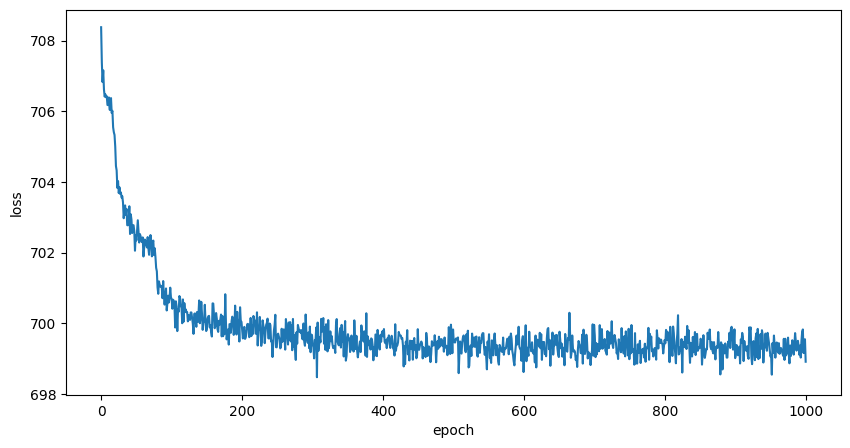

In [10]:
# Plot loss history of regular training

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

Text(0, 0.5, 'loss')

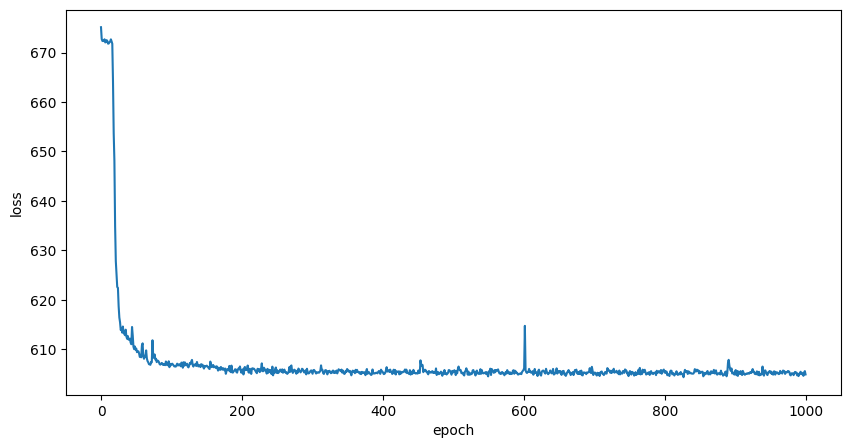

In [11]:
# Plot loss history of fairness training

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history_fair)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

In [12]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

100%|██████████| 227/227 [00:00<00:00, 438.42it/s]

(16281, 8)
(28941, 8)


              precision    recall  f1-score   support

           0       0.87      0.93      0.90     21741
           1       0.73      0.56      0.64      7200

    accuracy                           0.84     28941
   macro avg       0.80      0.75      0.77     28941
weighted avg       0.83      0.84      0.83     28941



c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


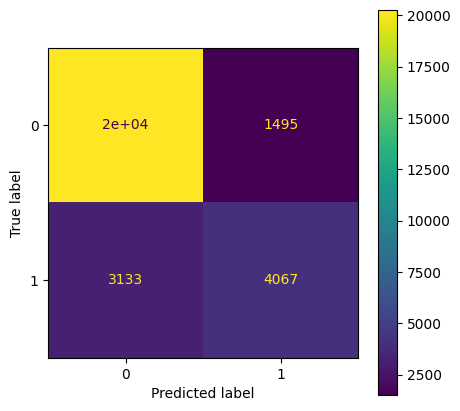

In [13]:
clf_vanilla = LogisticRegression()
# vanilla dataset: train the classifier on the original data
clf_vanilla.fit(train_data, train_target)
vanilla_predictions = clf_vanilla.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

           0       0.79      0.97      0.87     21741
           1       0.73      0.24      0.36      7200

    accuracy                           0.79     28941
   macro avg       0.76      0.60      0.61     28941
weighted avg       0.78      0.79      0.74     28941



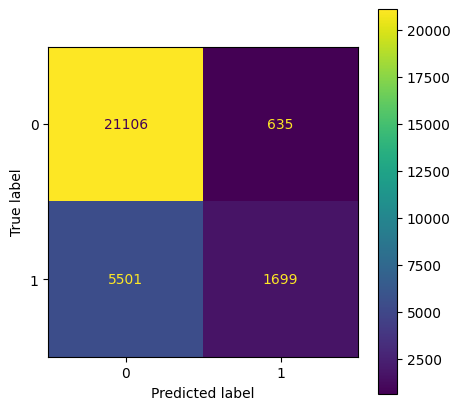

In [14]:
# embeddings dataset: train the classifier on the embeddings
clf = LogisticRegression()
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

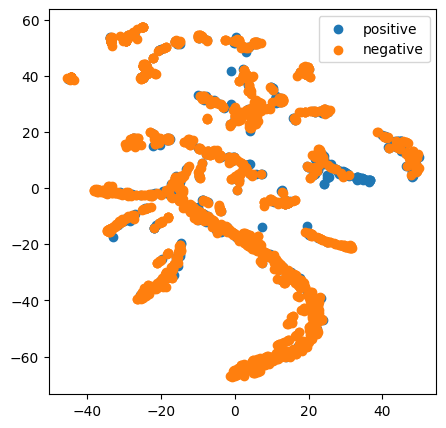

In [15]:
#Visualizing the embeddings with T-sne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings[:2000])
positive = train_target[:2000] == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

In [16]:
# Generate synthetic Data for fairness testing
def generate_synthetic_data(df):
    synthetic_data = {}
    for column in df.columns:
        if df[column].dtype in ["int64", "float64", "int8"]:
            # we make sure that the synthetic data is within the bounds of the original training data
            min_value = df[column].min()
            max_value = df[column].max()
            synthetic_data[column] = np.random.uniform(
                min_value, max_value, size=len(df)
            )
        elif df[column].dtype == "object":
            # choose a random string that has already been seen
            unique_values = df[column].unique()
            synthetic_data[column] = np.random.choice(unique_values, size=len(df))
        elif df[column].dtype == "bool":
            synthetic_data[column] = np.random.choice([True, False], size=len(df))
        else:
            synthetic_data[column] = [np.nan] * len(df)

    synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)
    return synthetic_df

fairness_test_df = generate_synthetic_data(train_data)

# the idea is that we create a synthetic dataset from which we generate flipped protected attribute pairs
fairness_test_ds = SCARFDataset(
    fairness_test_df.to_numpy().astype(float),
    train_target.to_numpy(),
    columns=fairness_test_df.columns,
)  # The other 2 parameters don't really matter

fairness_test_loader = DataLoader(
    fairness_test_ds, batch_size=batch_size, shuffle=False
)


In [17]:
# Testing Fairness
fairness_vanilla = []
fairness_embed = []

model.eval()

for _, x in fairness_test_df.iterrows():
    x_copy = x.to_frame().T
    
    # flip the protected attributes
    for attribute in protected:
        x_copy[attribute] = 1 - x_copy[attribute]
        
    vanilla_x = clf_vanilla.predict(x.values.reshape(1, -1))
    vanilla_x_copy = clf_vanilla.predict(x_copy.values.reshape(1, -1))
    # see if the model classifies them both as the same
    fairness_vanilla.append(1 if vanilla_x == vanilla_x_copy else 0)

for x in fairness_test_loader:
    x = x.to(device)
    x_copy = x.clone()
    for i in protected_indices:
        x_copy[i] = 1 - x[i]

    embed_x = model.get_embeddings(x).cpu().numpy()
    embed_x_copy = model.get_embeddings(x_copy).cpu().numpy()
    cl_x, cl_x_copy = clf.predict(embed_x), clf.predict(embed_x_copy)
    for (embed_pred_x, embed_pred_x_copy) in zip(cl_x, cl_x_copy):
        fairness_embed.append(1 if embed_pred_x == embed_pred_x_copy else 0)

vanilla_fair_score = np.mean(np.array(fairness_vanilla))
embed_fair_score = np.mean(np.array(fairness_embed))

c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\mxian\OneDrive\Desktop\Coding\226\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fit

In [18]:
print(vanilla_fair_score)
print(embed_fair_score)

0.9960076162397887
0.9848289417111971


              precision    recall  f1-score   support

           0       0.79      0.97      0.87     21741
           1       0.72      0.24      0.36      7200

    accuracy                           0.79     28941
   macro avg       0.76      0.61      0.62     28941
weighted avg       0.78      0.79      0.75     28941

0.9842761501136293


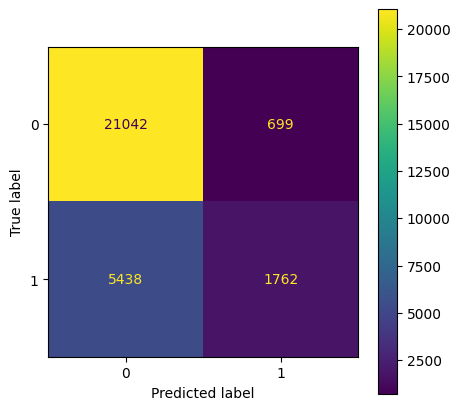

In [20]:
# Booster 
import xgboost as xgb
from sklearn.metrics import accuracy_score

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 1,
    "min_child_weight": 1,
    "verbosity": 0,
}

# generic xgb booster trained on the embeddings
dtrain = xgb.DMatrix(train_embeddings, label=train_target)
dtest = xgb.DMatrix(test_embeddings, label=test_target)

num_rounds = 100
booster_model = xgb.train(params, dtrain, num_rounds)

y_pred = booster_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
print(classification_report(test_target, y_pred_binary))
cm = confusion_matrix(test_target, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# same fairness testing code
fairness_booster = []
for x in fairness_test_loader:
    x = x.to(device)
    x_copy = x.clone()
    for i in protected_indices:
        x_copy[i] = 1 - x[i]

    embed_x = model.get_embeddings(x).cpu().numpy()
    embed_x_copy = model.get_embeddings(x_copy).cpu().numpy()
    dembed_x = xgb.DMatrix(embed_x)
    dembed_x_copy = xgb.DMatrix(embed_x_copy)
    cl_x, cl_x_copy = booster_model.predict(dembed_x), booster_model.predict(
        dembed_x_copy
    )
    for embed_pred_x, embed_pred_x_copy in zip(cl_x, cl_x_copy):
        fairness_booster.append(1 if embed_pred_x == embed_pred_x_copy else 0)

fairness_booster_score = np.mean(np.array(fairness_booster))
print(fairness_booster_score)